# Get data

In [2]:
# Get the data
import pandas as pd
data = pd.read_csv("EFC_Carbohydrate_Lignin_Temp.csv")
data

,Latitude,Longitude,Carbohydrate,Lignin,Lignin_cellulose,Temperature
0,37.901300,-109.5337,0.010842,0.001983,0.012825,8.10
1,37.918300,-109.5168,0.009939,0.001513,0.011452,8.10
2,44.466800,-109.6253,0.011010,0.001810,0.012820,3.00
3,45.263900,-110.8632,0.012625,0.001646,0.014271,6.10
4,33.594400,-109.1397,0.011597,0.001932,0.013529,8.80
...,...,...,...,...,...,...
599,42.453135,-76.3842,0.013111,0.002534,0.015645,7.73
600,42.453135,-76.3842,0.010618,0.002358,0.012976,7.73
601,42.453135,-76.3842,0.012489,0.002603,0.015092,7.73
602,42.453135,-76.3842,0.013208,0.002555,0.015763,7.73


# 1. Plot all

In [2]:
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt

def plot_function_of_temperature(df, y):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Temperature'], df[y], alpha=0.5)
    plt.title(f'{y} vs. Temperature')
    plt.xlabel('Temperature (°C)')
    plt.ylabel(y)
    plt.grid(True)
    plt.show()

@interact
def interactive_plot(y=['Lignin_cellulose', 'Lignin', 'Carbohydrate']):
    plot_function_of_temperature(data, y)

interactive(children=(Dropdown(description='y', options=('Lignin_cellulose', 'Lignin', 'Carbohydrate'), value=…

# 2. Plot Lignin_cellulose

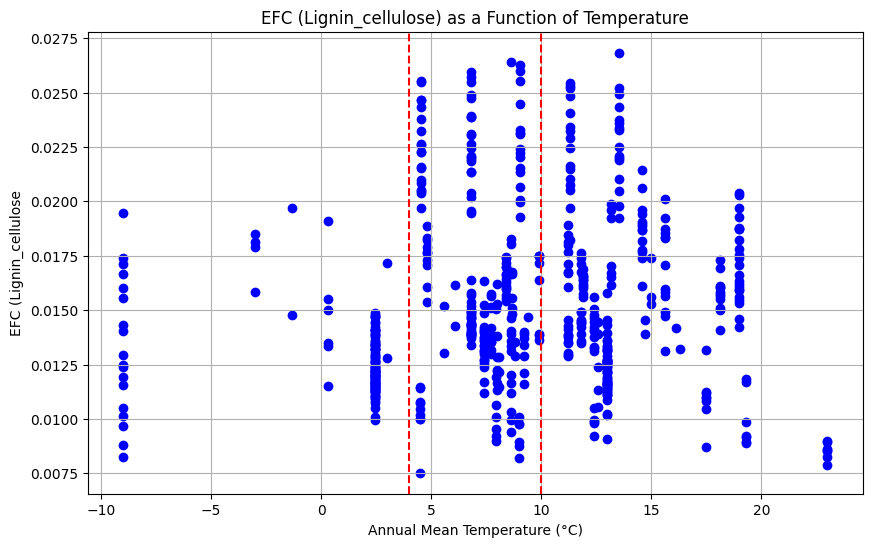

In [2]:
import matplotlib.pyplot as plt

# Scatterplot + vertical line
plt.figure(figsize=(10, 6))

# Plotting
plt.scatter(data['Temperature'], data['Lignin_cellulose'], color='blue')
plt.title('EFC (Lignin_cellulose) as a Function of Temperature')
plt.xlabel('Annual Mean Temperature (°C)')
plt.ylabel('EFC (Lignin_cellulose')
plt.grid(True)

# Adding red vertical lines
plt.axvline(x=4, color='red', linestyle='--')  # Added line

plt.axvline(x=10, color='red', linestyle='--')  # Added line

# Show plot
plt.show()

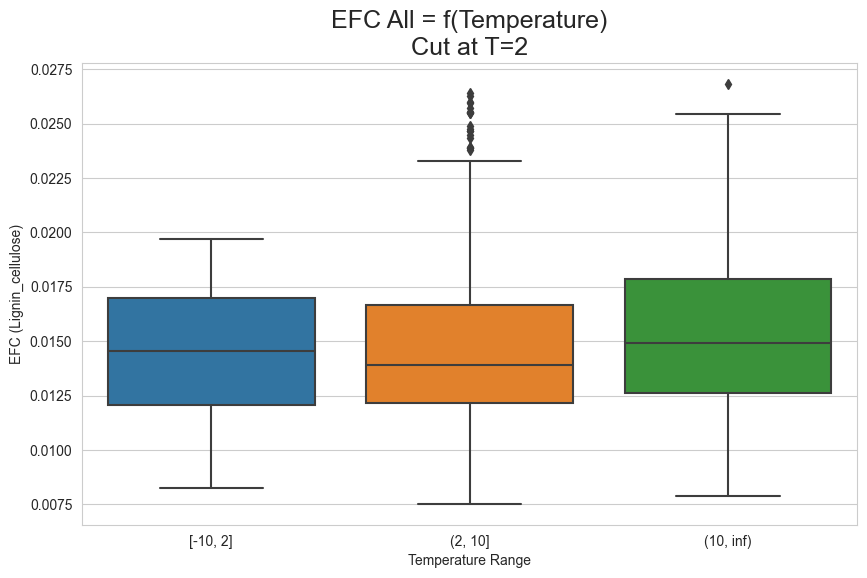

In [51]:
# Boxplot Lignin_cellulose
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

bound1 = 2
bound2 = 10

# Define temperature bins and labels for clustering
temperature_bins = [-float('inf'), bound1, bound2, float('inf')]
temperature_labels = [f'[-10, {bound1}]', f'({bound1}, {bound2}]', f'({bound2}, inf)']


# Bin the 'Temperature' data
data['Temperature_Range'] = pd.cut(data['Temperature'], bins=temperature_bins, labels=temperature_labels)

# Set the style of the visualization
sns.set_style("whitegrid")

# Create a boxplot of 'Lignin' as a function of 'Temperature_Range'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Temperature_Range', y='Lignin_cellulose', data=data)

plt.title('EFC All = f(Temperature)\nCut at T=2',fontsize=18)
plt.xlabel('Temperature Range')
plt.ylabel('EFC (Lignin_cellulose)')

# Show the plot
plt.show()

In [3]:
# Can I do an ANOVA?
# Test the normality of the data (Shapiro Test)
from scipy.stats import shapiro

# Test for normality within each temperature range group
normality_test_results = {}
for label in temperature_labels:
    group = data[data['Temperature_Range'] == label]['Lignin_cellulose']
    stat, p = shapiro(group)
    normality_test_results[label] = {'statistic': stat, 'p-value': p}

normality_test_results

# Interpretation
# H0: data are normally distributed.
# If pvalue<0.05, H0 is rejected. 
# Here all pvalues<0.05, so the data are not normally distributed.
# Alternative tests to ANOVA when data are not normally distributed: 
# one-way ANOVA analog, Kruskal-Wallis, and the two-sample t test analog, Mann-Whitney.

{'[-10, 4]': {'statistic': 0.9158855676651001,
  'p-value': 7.032497819636774e-07},
 '(4, 10]': {'statistic': 0.9407939910888672, 'p-value': 6.82647112171253e-08},
 '(10, inf)': {'statistic': 0.9736850261688232,
  'p-value': 0.00012911218800581992}}

In [52]:
# Statistical test
from scipy.stats import kruskal, mannwhitneyu

# Perform the Kruskal-Wallis test to check for overall differences
kruskal_test_result = kruskal(data[data['Temperature_Range'] == f'[-10, {bound1}]']['Lignin_cellulose'],
                              data[data['Temperature_Range'] == f'({bound1}, {bound2}]']['Lignin_cellulose'],
                              data[data['Temperature_Range'] == f'({bound2}, inf)']['Lignin_cellulose'])

print("Kruskal-Wallis test result:", kruskal_test_result)

# Perform Mann-Whitney U tests for each pair if Kruskal-Wallis test is significant
if kruskal_test_result.pvalue < 0.05:
    # Define groups for comparison
    group1 = data[data['Temperature_Range'] == f'[-10, {bound1}]']['Lignin_cellulose']
    group2 = data[data['Temperature_Range'] == f'({bound1}, {bound2}]']['Lignin_cellulose']
    group3 = data[data['Temperature_Range'] == f'({bound2}, inf)']['Lignin_cellulose']

    # Perform Mann-Whitney U tests
    mw_test_1_2 = mannwhitneyu(group1, group2, alternative='two-sided')
    mw_test_1_3 = mannwhitneyu(group1, group3, alternative='two-sided')
    mw_test_2_3 = mannwhitneyu(group2, group3, alternative='two-sided')

    # Adjust p-values for multiple comparisons (Bonferroni correction)
    n_comparisons = 3
    bonferroni_correction = lambda p: min(p * n_comparisons, 1)  # Adjusting p-values

    adjusted_p_1_2 = bonferroni_correction(mw_test_1_2.pvalue)
    adjusted_p_1_3 = bonferroni_correction(mw_test_1_3.pvalue)
    adjusted_p_2_3 = bonferroni_correction(mw_test_2_3.pvalue)

    print(f"Adjusted p-value for comparison between [-10, {bound1}] and ({bound1}, {bound2}]:", adjusted_p_1_2)
    print(f"Adjusted p-value for comparison between [-10, {bound1}] and ({bound2}, inf):", adjusted_p_1_3)
    print(f"Adjusted p-value for comparison between ({bound1}, {bound2}] and ({bound2}, inf):", adjusted_p_2_3)
    
# Interpretation
# H0: les k groupes sont confondus.
# Si pvalue<0.05, H0 est rejete. 
# Ici pvalue<0.05 donc les groupes ne sont pas confondus. Au moins 1 est different.
# Ensuite on fait un test Mann-Whitney U pour voir quelles paires sont differentes.
# pvalue<0.05 pour box 1-2 et box 1-3. Donc c'est la 1ere qui se distingue des 2 autres.

Kruskal-Wallis test result: KruskalResult(statistic=4.386455001777222, pvalue=0.11155611949017913)


In [ ]:
# Est-ce que j'ai toujours ce resultat si je coupe T a 2 (au lieu de 4)?
# Kruskal-Wallis pvalue>0.05, donc H0 est gardee, tous les groupes sont differents.

In [ ]:
# Est-ce que j'ai des boites significativement differentes pour la LIGNIN si je coupe a 4?


# 3. Plot Lignin

/Users/elsa/anaconda3/envs/dmenv/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


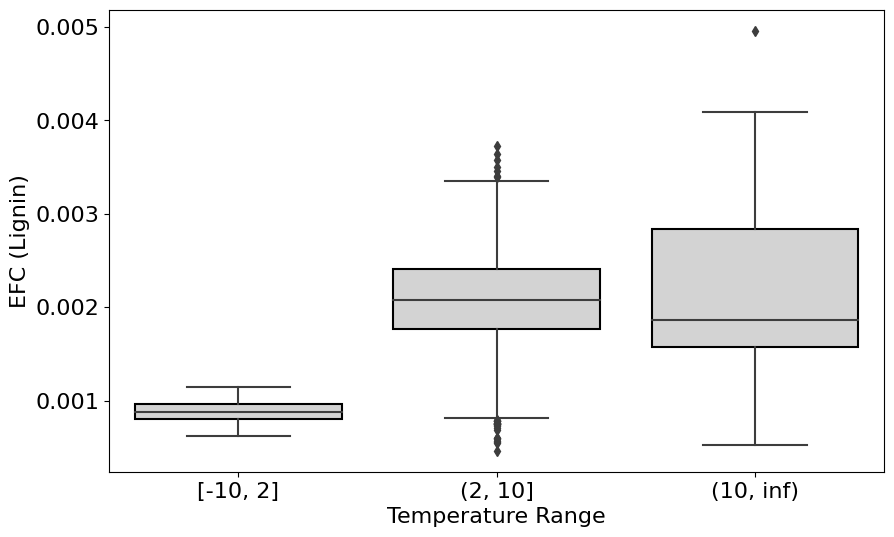

In [4]:
# Boxplot Lignin alone
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

bound1 = 2
bound2 = 10

# Define temperature bins and labels for clustering
temperature_bins = [-float('inf'), bound1, bound2, float('inf')]
temperature_labels = [f'[-10, {bound1}]', f'({bound1}, {bound2}]', f'({bound2}, inf)']


# Bin the 'Temperature' data
data['Temperature_Range'] = pd.cut(data['Temperature'], bins=temperature_bins, labels=temperature_labels)

# Create a boxplot of 'Lignin' as a function of 'Temperature_Range'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Temperature_Range', y='Lignin', data=data, boxprops=dict(facecolor='lightgrey', edgecolor='black'))

#plt.title('EFC Lignin = f(Temperature)\nCut at T=3',fontsize=18)
plt.xlabel('Temperature Range', fontsize=16)
plt.ylabel('EFC (Lignin)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)

# Show the plot
plt.show()

In [3]:
# Statistical test
from scipy.stats import kruskal, mannwhitneyu

# Perform the Kruskal-Wallis test to check for overall differences
kruskal_test_result = kruskal(data[data['Temperature_Range'] == f'[-10, {bound1}]']['Lignin'],
                              data[data['Temperature_Range'] == f'({bound1}, {bound2}]']['Lignin'],
                              data[data['Temperature_Range'] == f'({bound2}, inf)']['Lignin'])

print("Kruskal-Wallis test result:", kruskal_test_result)

# Perform Mann-Whitney U tests for each pair if Kruskal-Wallis test is significant
if kruskal_test_result.pvalue < 0.05:
    # Define groups for comparison
    group1 = data[data['Temperature_Range'] == f'[-10, {bound1}]']['Lignin']
    group2 = data[data['Temperature_Range'] == f'({bound1}, {bound2}]']['Lignin']
    group3 = data[data['Temperature_Range'] == f'({bound2}, inf)']['Lignin']

    # Perform Mann-Whitney U tests
    mw_test_1_2 = mannwhitneyu(group1, group2, alternative='two-sided')
    mw_test_1_3 = mannwhitneyu(group1, group3, alternative='two-sided')
    mw_test_2_3 = mannwhitneyu(group2, group3, alternative='two-sided')

    # Adjust p-values for multiple comparisons (Bonferroni correction)
    n_comparisons = 3
    bonferroni_correction = lambda p: min(p * n_comparisons, 1)  # Adjusting p-values

    adjusted_p_1_2 = bonferroni_correction(mw_test_1_2.pvalue)
    adjusted_p_1_3 = bonferroni_correction(mw_test_1_3.pvalue)
    adjusted_p_2_3 = bonferroni_correction(mw_test_2_3.pvalue)

    print(f"Adjusted p-value for comparison between [-10, {bound1}] and ({bound1}, {bound2}]:", adjusted_p_1_2)
    print(f"Adjusted p-value for comparison between [-10, {bound1}] and ({bound2}, inf):", adjusted_p_1_3)
    print(f"Adjusted p-value for comparison between ({bound1}, {bound2}] and ({bound2}, inf):", adjusted_p_2_3)
    
# Interpretation
# H0: les k groupes sont confondus.
# Si pvalue<0.05, H0 est rejete. 
# Ici pvalue<0.05 donc les groupes ne sont pas confondus. Au moins 1 est different.
# Ensuite on fait un test Mann-Whitney U pour voir quelles paires sont differentes.
# pvalue<0.05 pour box 1-2 et box 1-3. Donc c'est la 1ere qui se distingue des 2 autres.

Kruskal-Wallis test result: KruskalResult(statistic=0.8077359939377402, pvalue=0.6677322581336911)


In [ ]:
# Pour la Lignin, les boites sont differentes si on cut T a 2 (mais pas a 4).
# Alors que pour ALL, les boites sont differentes si on cut T a 4 (mais pas a 2).

# 4. Can I draw my analytical expression on either

In [1]:
# Get the data
import pandas as pd
data = pd.read_csv("EFC_Carbohydrate_Lignin_Temp.csv")
data

,Latitude,Longitude,Carbohydrate,Lignin,Lignin_cellulose,Temperature
0,37.901300,-109.5337,0.010842,0.001983,0.012825,8.10
1,37.918300,-109.5168,0.009939,0.001513,0.011452,8.10
2,44.466800,-109.6253,0.011010,0.001810,0.012820,3.00
3,45.263900,-110.8632,0.012625,0.001646,0.014271,6.10
4,33.594400,-109.1397,0.011597,0.001932,0.013529,8.80
...,...,...,...,...,...,...
599,42.453135,-76.3842,0.013111,0.002534,0.015645,7.73
600,42.453135,-76.3842,0.010618,0.002358,0.012976,7.73
601,42.453135,-76.3842,0.012489,0.002603,0.015092,7.73
602,42.453135,-76.3842,0.013208,0.002555,0.015763,7.73


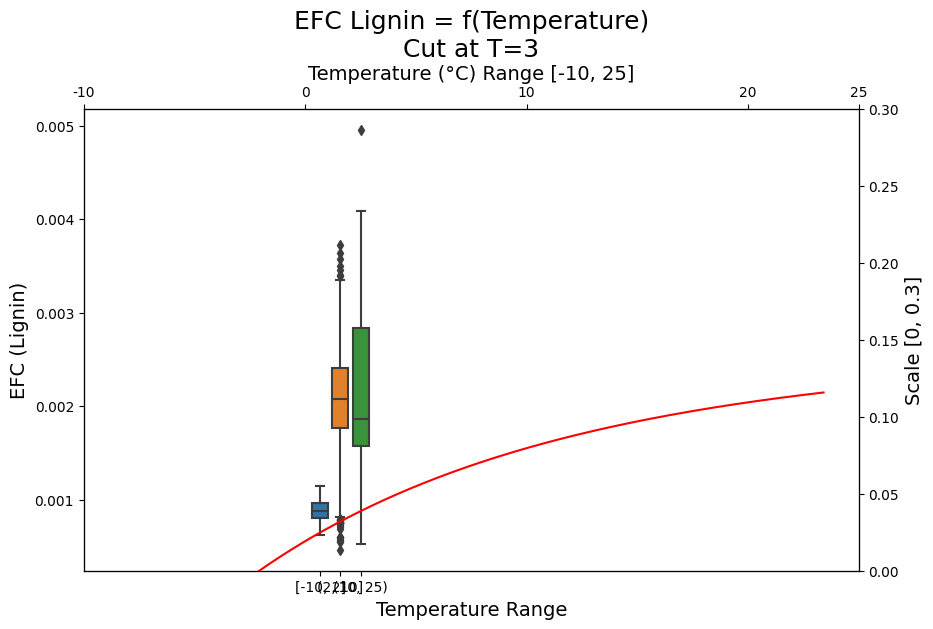

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load your data
# Ensure your data is loaded as 'data' DataFrame before running this code

# Parameters for the line equation
dM = 2e-4
γM = 0.31
c0 = 1.17
V0U = 1e5
EvU = 38
R = 8.314e-3  # Note the adjustment of R's value

# Define temperature bins and labels for clustering
temperature_bins = [-10, 2, 10, 25]
temperature_labels = [f'[-10, 2]', f'(2, 10]', f'(10, 25)']

# Bin the 'Temperature' data
data['Temperature_Range'] = pd.cut(data['Temperature'], bins=temperature_bins, labels=temperature_labels)

# Create the boxplot of 'Lignin' as a function of 'Temperature_Range'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Temperature_Range', y='Lignin', data=data)
plt.title('EFC Lignin = f(Temperature)\nCut at T=3', fontsize=18)
plt.xlabel('Temperature Range', fontsize=14)
plt.ylabel('EFC (Lignin)', fontsize=14)

# Create an additional x-axis on top
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlim([-10, 25])
ax2.set_xticks([-10, 0, 10, 20, 25])
ax2.set_xticklabels(['-10', '0', '10', '20', '25'])
ax2.set_xlabel('Temperature (°C) Range [-10, 25]', fontsize=14)

# Create a second y-axis on the right
ax3 = ax1.twinx()
ax3.set_ylim([0, 0.3])
ax3.set_ylabel('Scale [0, 0.3]', fontsize=14)

# Temperature range for plotting the φ*(T) line
temperature_range_line = np.linspace(-10, 25, 400)

# Calculate φ*(T) using the provided equation
phi_star_T = 1 - dM / (γM * V0U * np.exp(-(EvU / (R * (temperature_range_line + 273))))) - 1 / c0

# Plot φ*(T) on the second y-axis
ax3.plot(temperature_range_line, phi_star_T, 'r-', label='φ*(T)')

plt.show()


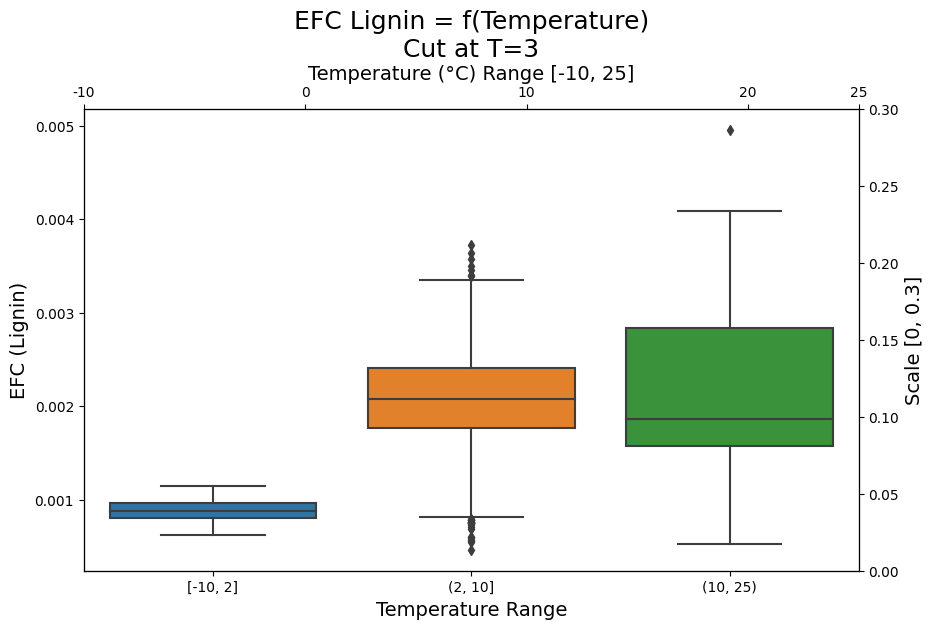

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming data is previously loaded into a DataFrame named `data`
# Define temperature bins and labels for clustering, if not already done
temperature_bins = [-10, 2, 10, 25]
temperature_labels = [f'[-10, 2]', f'(2, 10]', f'(10, 25)']

# Bin the 'Temperature' data
data['Temperature_Range'] = pd.cut(data['Temperature'], bins=temperature_bins, labels=temperature_labels)

# Create the boxplot of 'Lignin' as a function of 'Temperature_Range'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Temperature_Range', y='Lignin', data=data)
plt.title('EFC Lignin = f(Temperature)\nCut at T=3', fontsize=18)
plt.xlabel('Temperature Range', fontsize=14)
plt.ylabel('EFC (Lignin)', fontsize=14)

# Create an additional x-axis on top
ax1 = plt.gca()  # Get the current Axes instance
ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
ax2.set_xlim([-10, 25])
ax2.set_xticks([-10, 0, 10, 20, 25])  # Setting ticks for the temperature range
ax2.set_xticklabels(['-10', '0', '10', '20', '25'])  # Labeling the ticks
ax2.set_xlabel('Temperature (°C) Range [-10, 25]', fontsize=14)

# Adding a second y-axis on the right
ax3 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
ax3.set_ylim([0, 0.3])  # Set the y-axis range from 0 to 0.3
ax3.set_ylabel('Scale [0, 0.3]', fontsize=14)  # Label for the new y-axis

plt.show()

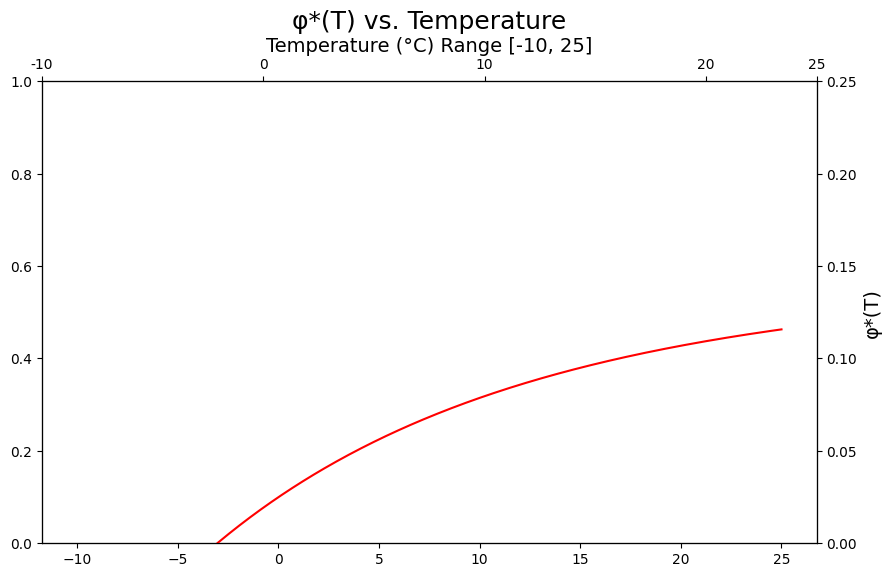

In [7]:
# Removing the boxplots and drawing only the φ*(T) line with the specified parameters, using the additional axes.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the parameters for φ*(T) again for clarity
dM = 2e-4
γM = 0.31
c0 = 1.17
V0U = 1e5
EvU = 38
R = 8.314e-3  # Adjusted value of R

# Temperature range for plotting φ*(T), aligned with the top x-axis range
temperature_range_line = np.linspace(-10, 25, 400)

# Calculate φ*(T) using the provided equation
phi_star_T = 1 - dM / (γM * V0U * np.exp(-(EvU / (R * (temperature_range_line + 273))))) - 1 / c0

# Setup the figure and axes
f = plt.figure(figsize=(10, 6))
ax1 = plt.gca()

# Setup the additional x-axis on top
ax2 = ax1.twiny()
ax2.set_xlim([-10, 25])
ax2.set_xticks([-10, 0, 10, 20, 25])
ax2.set_xticklabels(['-10', '0', '10', '20', '25'])
ax2.set_xlabel('Temperature (°C) Range [-10, 25]', fontsize=14)

# Setup the additional y-axis on the right
ax3 = ax1.twinx()
ax3.set_ylim([0, 0.25])
ax3.set_ylabel('φ*(T)', fontsize=14)

# Plot φ*(T) on the second y-axis
ax3.plot(temperature_range_line, phi_star_T, 'r-', label='φ*(T)')

plt.title('φ*(T) vs. Temperature', fontsize=18)

plt.show()
f.savefig("fig_phi.pdf", bbox_inches='tight')

# Supp plots

## 2.2 Curve fit

### 2.2.1 Using ML

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Prepare data
x_data = np.array(data['Temperature'])
y_data = np.array(data['Lignin'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    x_data.reshape(-1, 1), y_data, test_size=0.2, random_state=0)

# Initialize models
linear_model = LinearRegression()
poly_model = LinearRegression()
decision_tree_model = DecisionTreeRegressor(random_state=0)
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the linear model
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
r2_linear = r2_score(y_test, y_pred_linear)

# Fit polynomial model (degree 2)
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)
r2_poly = r2_score(y_test, y_pred_poly)

# Fit decision tree model
decision_tree_model.fit(X_train, y_train)
y_pred_decision_tree = decision_tree_model.predict(X_test)
r2_decision_tree = r2_score(y_test, y_pred_decision_tree)

# Fit random forest model
random_forest_model.fit(X_train, y_train)
y_pred_random_forest = random_forest_model.predict(X_test)
r2_random_forest = r2_score(y_test, y_pred_random_forest)

# Compile results
model_performance = {
    "Linear Regression": r2_linear,
    "Polynomial Regression": r2_poly,
    "Decision Tree Regression": r2_decision_tree,
    "Random Forest Regression": r2_random_forest
}

model_performance

ValueError: Input y contains NaN.

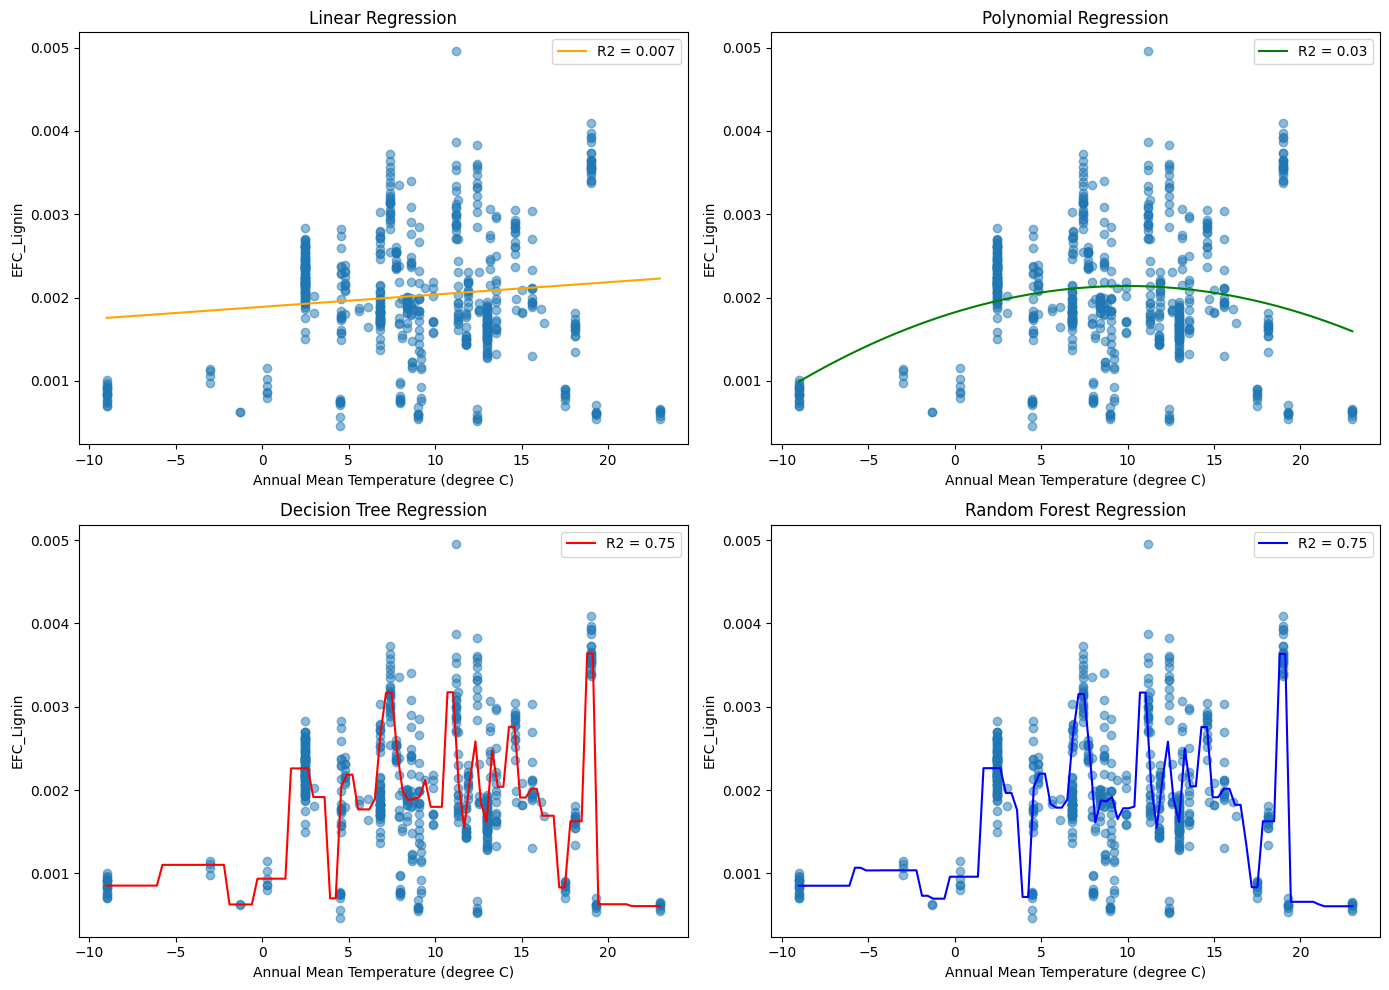

In [4]:
# Plot 
# Generating plots for each model

# Range of x values for plotting the models
x_range = np.linspace(min(x_data), max(x_data), 100).reshape(-1, 1)
x_range_poly = poly_features.transform(x_range)

# Predictions for each model
y_pred_linear_plot = linear_model.predict(x_range)
y_pred_poly_plot = poly_model.predict(x_range_poly)
y_pred_decision_tree_plot = decision_tree_model.predict(x_range)
y_pred_random_forest_plot = random_forest_model.predict(x_range)

# Plotting
plt.figure(figsize=(14, 10))

# Linear Regression
plt.subplot(2, 2, 1)
plt.scatter(x_data, y_data, alpha=0.5)
plt.plot(x_range, y_pred_linear_plot, color='orange', label='R2 = 0.007')
plt.xlabel('Annual Mean Temperature (degree C)')
plt.ylabel('EFC_Lignin')
plt.title('Linear Regression')
plt.legend()

# Polynomial Regression
plt.subplot(2, 2, 2)
plt.scatter(x_data, y_data, alpha=0.5)
plt.plot(x_range, y_pred_poly_plot, color='green', label='R2 = 0.03')
plt.xlabel('Annual Mean Temperature (degree C)')
plt.ylabel('EFC_Lignin')
plt.title('Polynomial Regression')
plt.legend()

# Decision Tree Regression
plt.subplot(2, 2, 3)
plt.scatter(x_data, y_data, alpha=0.5)
plt.plot(x_range, y_pred_decision_tree_plot, color='red', label='R2 = 0.75')
plt.xlabel('Annual Mean Temperature (degree C)')
plt.ylabel('EFC_Lignin')
plt.title('Decision Tree Regression')
plt.legend()

# Random Forest Regression
plt.subplot(2, 2, 4)
plt.scatter(x_data, y_data, alpha=0.5)
plt.plot(x_range, y_pred_random_forest_plot, color='blue', label='R2 = 0.75')
plt.xlabel('Annual Mean Temperature (degree C)')
plt.ylabel('EFC_Lignin')
plt.title('Random Forest Regression')
plt.legend()

plt.tight_layout()
plt.show()

### 2.2.2 Exponential 

In [4]:
import numpy as np
from scipy.optimize import curve_fit

# Curve fit
def func(x,a,b,c):
    return a * np.exp(-b*x) + c

# Prepare data
x = np.array(data['Temperature'])
y = np.array(data['Lignin'])

popt, pcov = curve_fit(func, x, y)
a, b, c = popt

x_line = np.arange(min(x), max(x), 0.01)
x_line = np.reshape(x_line,(-1,1))

y_line = func(x_line, a, b, c)
y_line = np.reshape(y_line,(-1,1))

plt.scatter(x,y,alpha=0.5)
plt.scatter(x, y)
plt.plot(x_line,y_line, c='blue')

residuals = y - func(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

print("{:.2e}*exp(-{:.1f}x + {:.3f})".format(a, b, c))
print('r_squared =', r_squared)

plt.show()

ValueError: array must not contain infs or NaNs

### 2.2.3 Logistic function

In [5]:
# Logistic fitting function
def logistic_func(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Prepare data
x = np.array(data['Temperature'])
y = np.array(data['Lignin'])

# Curve fitting for a logistic model
popt_logistic, pcov_logistic = curve_fit(logistic_func, x, y, maxfev=10000)
L, k, x0 = popt_logistic
y_line_logistic = logistic_func(x_line, L, k, x0)

# Calculating R-squared for the logistic model
residuals_logistic = y - logistic_func(x, *popt_logistic)
ss_res_logistic = np.sum(residuals_logistic**2)
r_squared_logistic = 1 - (ss_res_logistic / ss_tot)

# Plotting
plt.scatter(x, y, alpha=0.5, label='Data')
plt.plot(x_line, y_line_logistic, c='green', label='Fitted curve (Logistic)')
plt.xlabel('Annual Mean Temperature (degree C)')
plt.ylabel('EFC_C-rich SOM')
plt.title('Logistic Curve Fitting (R2=0.0163)')
plt.legend()

# Print the fitted function and R-squared value for the logistic model
print("Fitted logistic function: L/(1 + e^(-k(x - x0))) with L = {:.2f}, k = {:.2f}, x0 = {:.2f}".format(L, k, x0))
print("R-squared for logistic model:", r_squared_logistic)

plt.show()

ValueError: array must not contain infs or NaNs

## 2.3 Clustering

### 2.3.1 Same as Yang

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set_style("whitegrid")

# Create a boxplot of 'Lignin' as a function of 'Temperature_Range'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Temperature_Range', y='Lignin', data=data)

plt.title('Boxplot of Lignin by Temperature Range')
plt.xlabel('Temperature Range')
plt.ylabel('Lignin')

# Show the plot
plt.show()

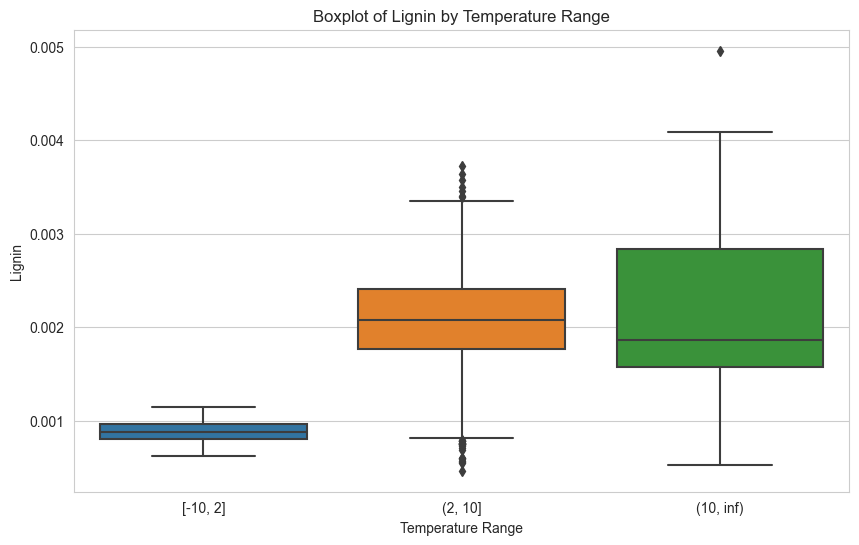

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define temperature bins and labels for clustering
temperature_bins = [-float('inf'), 2, 10, float('inf')]
temperature_labels = ['[-10, 2]', '(2, 10]', '(10, inf)']

# Bin the 'Temperature' data
data['Temperature_Range'] = pd.cut(data['Temperature'], bins=temperature_bins, labels=temperature_labels)

# Set the style of the visualization
sns.set_style("whitegrid")

# Create a boxplot of 'Lignin' as a function of 'Temperature_Range'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Temperature_Range', y='Lignin', data=data)

plt.title('Boxplot of Lignin by Temperature Range')
plt.xlabel('Temperature Range')
plt.ylabel('Lignin')

# Show the plot
plt.show()

# 1. Full Data

In [3]:
# Get the data
data = pd.read_csv("EFC_C_Temperature.csv")
data

x = np.array(data['Annual Mean Temperature (degree C)'])
y = np.array(data['EFC_C-rich SOM'])

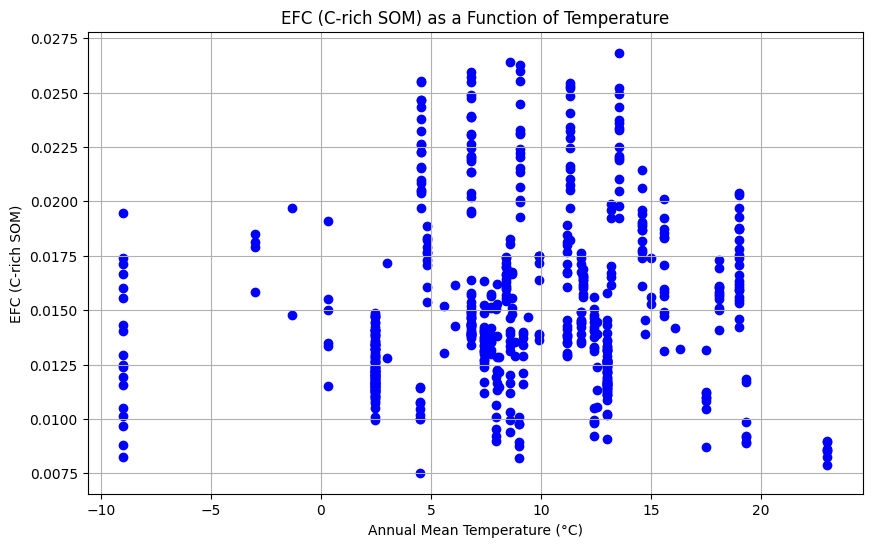

In [4]:
# Now that we have the data, let's plot EFC_C-rich SOM as a function of the Annual Mean Temperature
plt.figure(figsize=(10, 6))

# Plotting
plt.scatter(data['Annual Mean Temperature (degree C)'], data['EFC_C-rich SOM'], color='blue')
plt.title('EFC (C-rich SOM) as a Function of Temperature')
plt.xlabel('Annual Mean Temperature (°C)')
plt.ylabel('EFC (C-rich SOM)')
plt.grid(True)

# Show plot
plt.show()

## 1.1 Curve fit

### 1.1.1 Different shapes

-1.05e-09*exp(-1.6x + 0.015)
0.006856815078779888


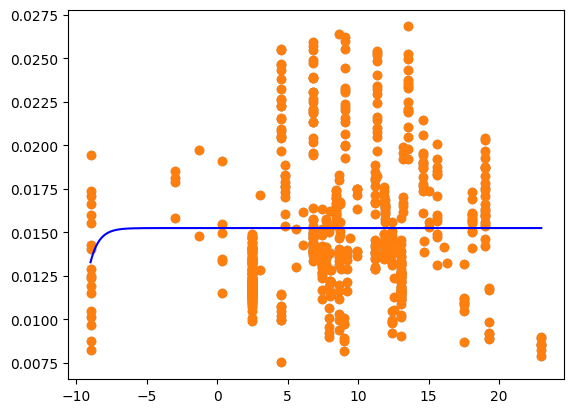

In [7]:
# Curve fit
def func(x,a,b,c):
    return a * np.exp(-b*x) + c

popt, pcov = curve_fit(func, x, y)
a, b, c = popt

x_line = np.arange(min(x), max(x), 0.01)
x_line = np.reshape(x_line,(-1,1))

y_line = func(x_line, a, b, c)
y_line = np.reshape(y_line,(-1,1))

plt.scatter(x,y,alpha=0.5)
plt.scatter(x, y)
plt.plot(x_line,y_line, c='blue')

residuals = y - func(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

print("{:.2e}*exp(-{:.1f}x + {:.3f})".format(a, b, c))
print(r_squared)

plt.show()


Fitted polynomial function: -1.07e-05 * x^2 + 2.19e-04 * x^1 + 1.45e-02 * x^0
R-squared for polynomial model: 0.03130013108511975


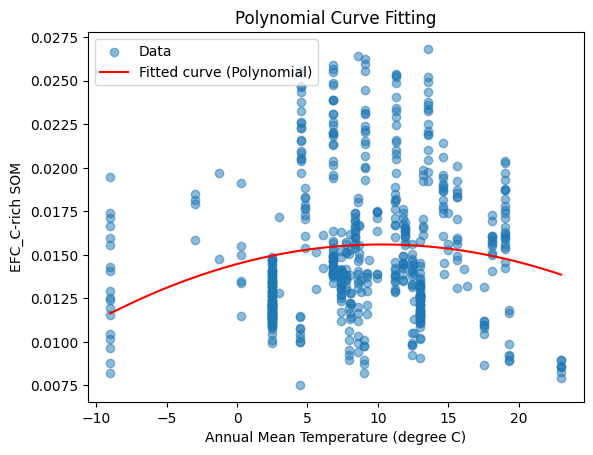

In [8]:
# Polynomial fitting function
def poly_func(x, *coeffs):
    return np.polyval(coeffs, x)

# Trying with a quadratic model (degree 2)
degree = 2

# Curve fitting for a polynomial model
popt_poly, pcov_poly = curve_fit(poly_func, x, y, p0=np.ones(degree + 1))
y_line_poly = poly_func(x_line, *popt_poly)

# Calculating R-squared for the polynomial model
residuals_poly = y - poly_func(x, *popt_poly)
ss_res_poly = np.sum(residuals_poly**2)
r_squared_poly = 1 - (ss_res_poly / ss_tot)

# Plotting
plt.scatter(x, y, alpha=0.5, label='Data')
plt.plot(x_line, y_line_poly, c='red', label='Fitted curve (Polynomial)')
plt.xlabel('Annual Mean Temperature (degree C)')
plt.ylabel('EFC_C-rich SOM')
plt.title('Polynomial Curve Fitting')
plt.legend()

# Print the fitted function and R-squared value for the polynomial model
polynomial_equation = ' + '.join([f"{coef:.2e} * x^{degree - i}" for i, coef in enumerate(popt_poly)])
print("Fitted polynomial function:", polynomial_equation)
print("R-squared for polynomial model:", r_squared_poly)

plt.show()


Fitted logistic function: L/(1 + e^(-k(x - x0))) with L = 0.02, k = 0.11, x0 = -21.35
R-squared for logistic model: 0.016285462506608894


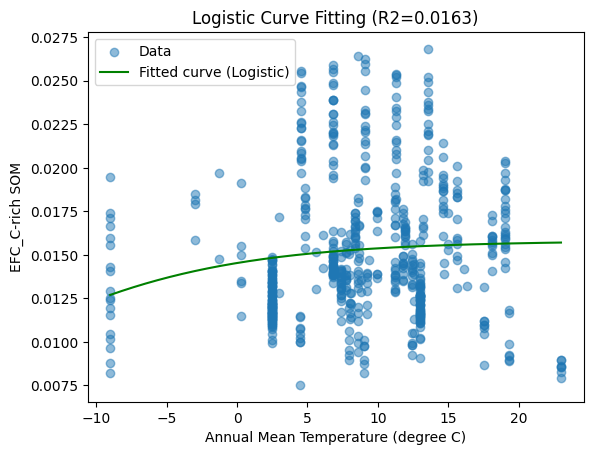

In [10]:
# Logistic fitting function
def logistic_func(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Curve fitting for a logistic model
popt_logistic, pcov_logistic = curve_fit(logistic_func, x, y, maxfev=10000)
L, k, x0 = popt_logistic
y_line_logistic = logistic_func(x_line, L, k, x0)

# Calculating R-squared for the logistic model
residuals_logistic = y - logistic_func(x, *popt_logistic)
ss_res_logistic = np.sum(residuals_logistic**2)
r_squared_logistic = 1 - (ss_res_logistic / ss_tot)

# Plotting
plt.scatter(x, y, alpha=0.5, label='Data')
plt.plot(x_line, y_line_logistic, c='green', label='Fitted curve (Logistic)')
plt.xlabel('Annual Mean Temperature (degree C)')
plt.ylabel('EFC_C-rich SOM')
plt.title('Logistic Curve Fitting (R2=0.0163)')
plt.legend()

# Print the fitted function and R-squared value for the logistic model
print("Fitted logistic function: L/(1 + e^(-k(x - x0))) with L = {:.2f}, k = {:.2f}, x0 = {:.2f}".format(L, k, x0))
print("R-squared for logistic model:", r_squared_logistic)

plt.show()

### 1.1.2 Use ML to find the best logistic model

Best Model Parameters: [ 1.59440158e-02  9.89908623e-02 -2.47526466e+01]
Best R-squared: 0.015756704777804553


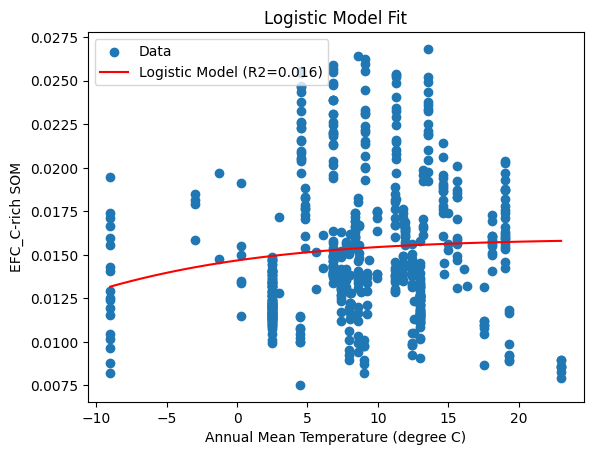

In [12]:
# Find the logistic model with the highest R-squared
## result: the R-squared found is slightly lower than the one above because it was calculated with a cross-validation, 
## which is more robust.

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

# Define the logistic function
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Prepare data
x_data = np.array(data['Annual Mean Temperature (degree C)'])
y_data = np.array(data['EFC_C-rich SOM'])

# Initialize variables to track the best model
best_r_squared = -np.inf
best_params = None

# Number of splits for cross-validation
n_splits = 5

# KFold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)

for train_index, test_index in kf.split(x_data):
    # Split data
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    # Fit logistic model
    popt, _ = curve_fit(logistic, x_train, y_train, maxfev=10000)

    # Predict on test set and calculate R-squared
    y_pred = logistic(x_test, *popt)
    r_squared = r2_score(y_test, y_pred)

    # Update best model if current model is better
    if r_squared > best_r_squared:
        best_r_squared = r_squared
        best_params = popt

# Print the best model parameters and R-squared value
print("Best Model Parameters:", best_params)
print("Best R-squared:", best_r_squared)

# Scatter plot of the actual data
plt.scatter(x, y, label='Data')

# Generate a range of x values for plotting the logistic model
x_model = np.linspace(min(x), max(x), 100)
# Compute the predicted y values
y_model = logistic(x_model, *best_params)

# Plot the logistic model
plt.plot(x_model, y_model, label='Logistic Model (R2=0.016)', color='red')

# Add labels and legend
plt.xlabel('Annual Mean Temperature (degree C)')
plt.ylabel('EFC_C-rich SOM')
plt.title('Logistic Model Fit')
plt.legend()

# Show the plot
plt.show()

### 1.1.3 Use ML to find the best fitting model

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Prepare data
x_data = np.array(data['Annual Mean Temperature (degree C)'])
y_data = np.array(data['EFC_C-rich SOM'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    x_data.reshape(-1, 1), y_data, test_size=0.2, random_state=0)

# Initialize models
linear_model = LinearRegression()
poly_model = LinearRegression()
decision_tree_model = DecisionTreeRegressor(random_state=0)
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the linear model
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
r2_linear = r2_score(y_test, y_pred_linear)

# Fit polynomial model (degree 2)
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)
r2_poly = r2_score(y_test, y_pred_poly)

# Fit decision tree model
decision_tree_model.fit(X_train, y_train)
y_pred_decision_tree = decision_tree_model.predict(X_test)
r2_decision_tree = r2_score(y_test, y_pred_decision_tree)

# Fit random forest model
random_forest_model.fit(X_train, y_train)
y_pred_random_forest = random_forest_model.predict(X_test)
r2_random_forest = r2_score(y_test, y_pred_random_forest)

# Compile results
model_performance = {
    "Linear Regression": r2_linear,
    "Polynomial Regression": r2_poly,
    "Decision Tree Regression": r2_decision_tree,
    "Random Forest Regression": r2_random_forest
}

model_performance

{'Linear Regression': 0.006669049171809216,
 'Polynomial Regression': 0.029976935707124674,
 'Decision Tree Regression': 0.745238640978004,
 'Random Forest Regression': 0.7454090892567387}

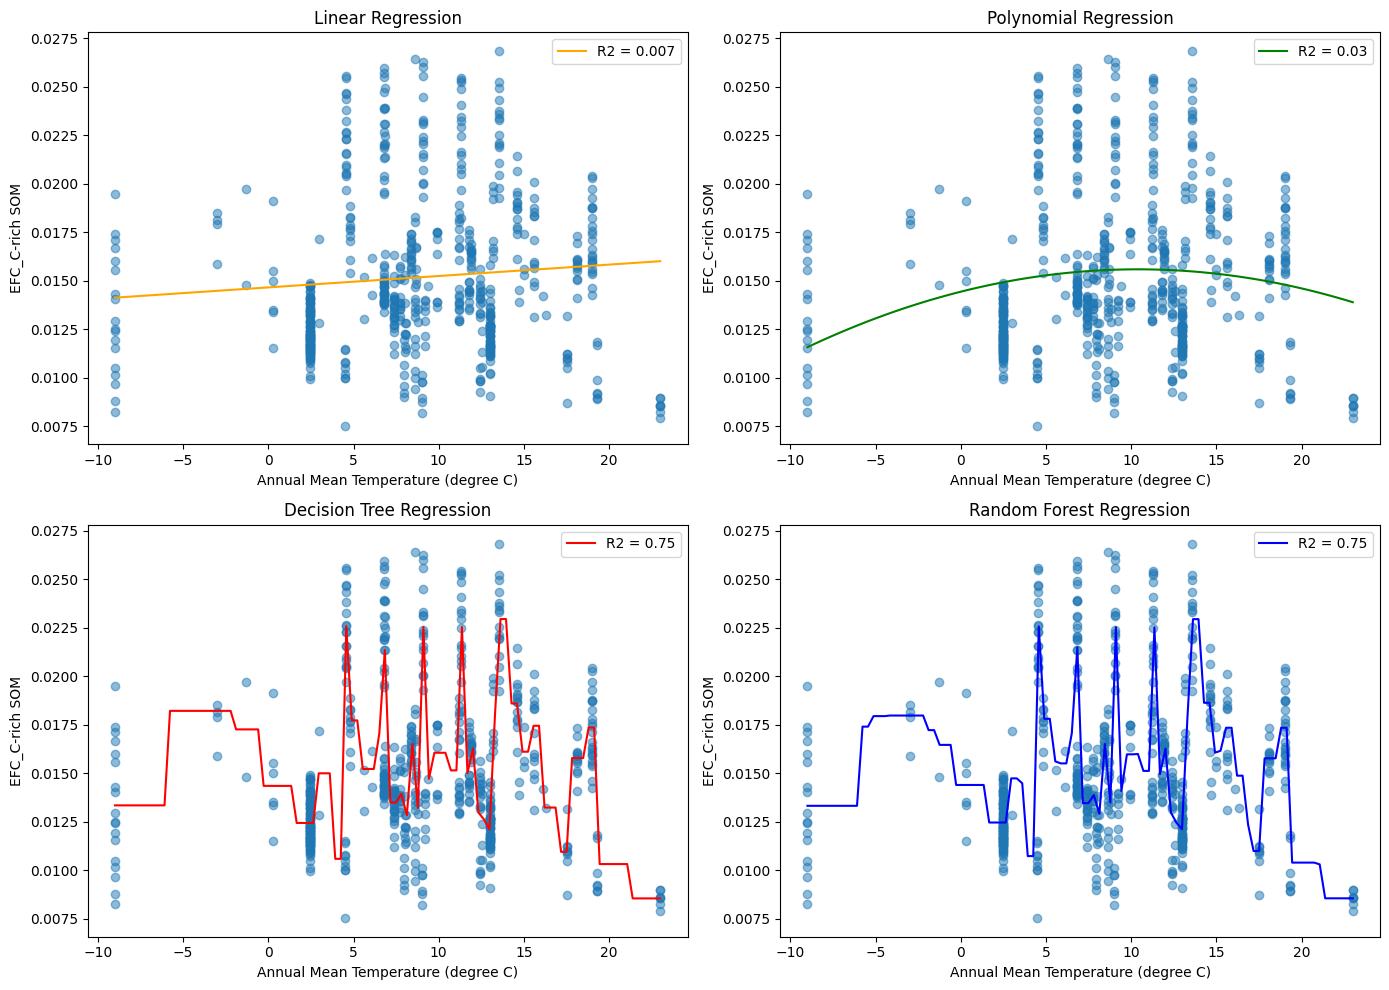

In [7]:
# Plot 
# Generating plots for each model

# Range of x values for plotting the models
x_range = np.linspace(min(x_data), max(x_data), 100).reshape(-1, 1)
x_range_poly = poly_features.transform(x_range)

# Predictions for each model
y_pred_linear_plot = linear_model.predict(x_range)
y_pred_poly_plot = poly_model.predict(x_range_poly)
y_pred_decision_tree_plot = decision_tree_model.predict(x_range)
y_pred_random_forest_plot = random_forest_model.predict(x_range)

# Plotting
plt.figure(figsize=(14, 10))

# Linear Regression
plt.subplot(2, 2, 1)
plt.scatter(x_data, y_data, alpha=0.5)
plt.plot(x_range, y_pred_linear_plot, color='orange', label='R2 = 0.007')
plt.xlabel('Annual Mean Temperature (degree C)')
plt.ylabel('EFC_C-rich SOM')
plt.title('Linear Regression')
plt.legend()

# Polynomial Regression
plt.subplot(2, 2, 2)
plt.scatter(x_data, y_data, alpha=0.5)
plt.plot(x_range, y_pred_poly_plot, color='green', label='R2 = 0.03')
plt.xlabel('Annual Mean Temperature (degree C)')
plt.ylabel('EFC_C-rich SOM')
plt.title('Polynomial Regression')
plt.legend()

# Decision Tree Regression
plt.subplot(2, 2, 3)
plt.scatter(x_data, y_data, alpha=0.5)
plt.plot(x_range, y_pred_decision_tree_plot, color='red', label='R2 = 0.75')
plt.xlabel('Annual Mean Temperature (degree C)')
plt.ylabel('EFC_C-rich SOM')
plt.title('Decision Tree Regression')
plt.legend()

# Random Forest Regression
plt.subplot(2, 2, 4)
plt.scatter(x_data, y_data, alpha=0.5)
plt.plot(x_range, y_pred_random_forest_plot, color='blue', label='R2 = 0.75')
plt.xlabel('Annual Mean Temperature (degree C)')
plt.ylabel('EFC_C-rich SOM')
plt.title('Random Forest Regression')
plt.legend()

plt.tight_layout()
plt.show()

### 1.1.4 Use ML to find the best polynomial regression

In [19]:
# Testing various degrees for polynomial regression and finding the best one

max_degree = 10  # Maximum degree to test
best_r2 = -np.inf
best_degree = 0
best_model = None

for degree in range(1, max_degree + 1):
    # Create polynomial features
    poly_features_degree = PolynomialFeatures(degree=degree)
    X_train_poly_degree = poly_features_degree.fit_transform(X_train)
    X_test_poly_degree = poly_features_degree.transform(X_test)

    # Fit the model
    model = LinearRegression()
    model.fit(X_train_poly_degree, y_train)

    # Predict and calculate R-squared
    y_pred_degree = model.predict(X_test_poly_degree)
    r2 = r2_score(y_test, y_pred_degree)

    # Update best degree and R-squared
    if r2 > best_r2:
        best_r2 = r2
        best_degree = degree
        best_model = model

best_r2, best_degree

(0.08661532678158368, 6)

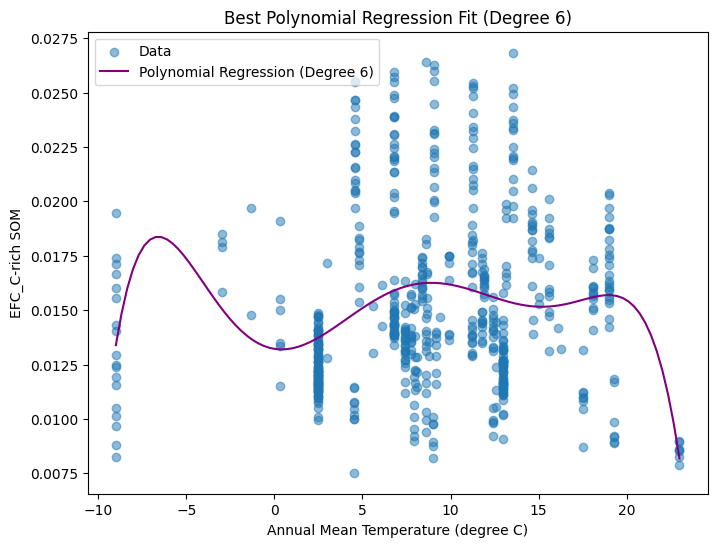

In [20]:
# Plot
# Generating the plot for the best polynomial regression model (degree 6)

# Creating polynomial features for the best degree
poly_features_best = PolynomialFeatures(degree=best_degree)
X_range_poly_best = poly_features_best.fit_transform(x_range)

# Predictions using the best polynomial model
y_pred_poly_best = best_model.predict(X_range_poly_best)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, alpha=0.5, label='Data')
plt.plot(x_range, y_pred_poly_best, color='purple', label=f'Polynomial Regression (Degree {best_degree})')
plt.xlabel('Annual Mean Temperature (degree C)')
plt.ylabel('EFC_C-rich SOM')
plt.title(f'Best Polynomial Regression Fit (Degree {best_degree})')
plt.legend()
plt.show()

### 1.1.5 Use ML to find the best polynomial regression of degree 2

In [21]:
# Fitting a Polynomial Regression model of degree 2

# Create polynomial features of degree 2
poly_features_degree_2 = PolynomialFeatures(degree=2)
X_train_poly_2 = poly_features_degree_2.fit_transform(X_train)
X_test_poly_2 = poly_features_degree_2.transform(X_test)

# Fit the model
model_degree_2 = LinearRegression()
model_degree_2.fit(X_train_poly_2, y_train)

# Predict and calculate R-squared
y_pred_degree_2 = model_degree_2.predict(X_test_poly_2)
r2_degree_2 = r2_score(y_test, y_pred_degree_2)

r2_degree_2

0.029976935707124674

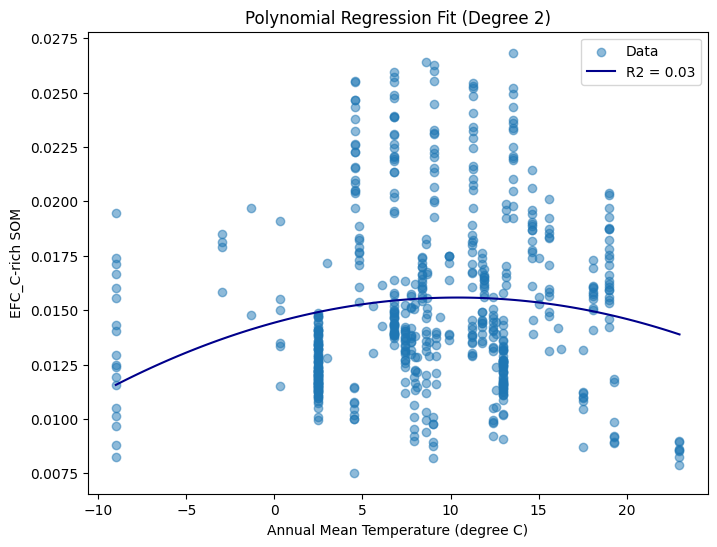

In [23]:
# Plot

# Generating the plot for the Polynomial Regression model of degree 2

# Creating polynomial features for degree 2
X_range_poly_2 = poly_features_degree_2.transform(x_range)

# Predictions using the degree 2 polynomial model
y_pred_poly_2 = model_degree_2.predict(X_range_poly_2)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, alpha=0.5, label='Data')
plt.plot(x_range, y_pred_poly_2, color='darkblue', label='R2 = 0.03')
plt.xlabel('Annual Mean Temperature (degree C)')
plt.ylabel('EFC_C-rich SOM')
plt.title('Polynomial Regression Fit (Degree 2)')
plt.legend()
plt.show()

## 1.2 Clustering

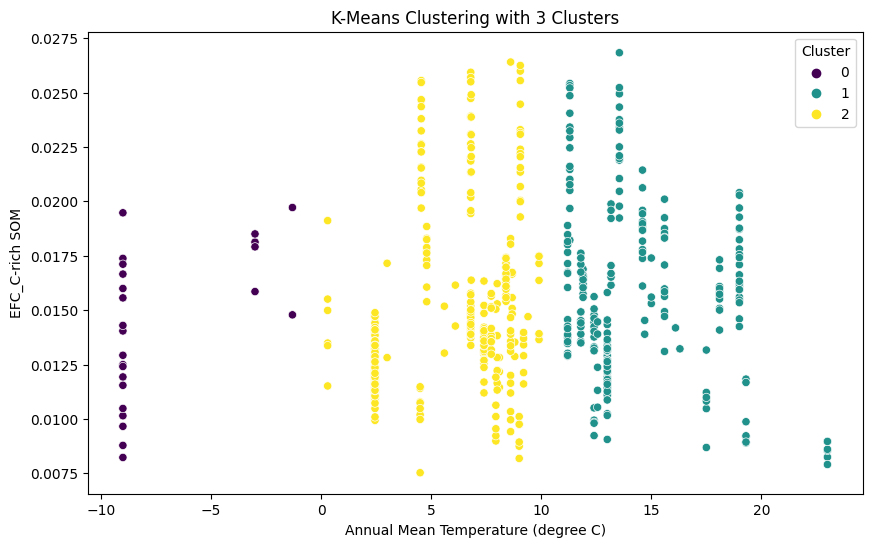

In [30]:
# Cluster data
# Applying K-means clustering with a chosen number of clusters (e.g., 3)
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(data[['Annual Mean Temperature (degree C)', 'EFC_C-rich SOM']])
data['Cluster'] = kmeans.labels_

# Visualizing the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Mean Temperature (degree C)', y='EFC_C-rich SOM', hue='Cluster', palette='viridis', data=data)
plt.title(f'K-Means Clustering with {num_clusters} Clusters')
plt.xlabel('Annual Mean Temperature (degree C)')
plt.ylabel('EFC_C-rich SOM')
plt.legend(title='Cluster')
plt.show()

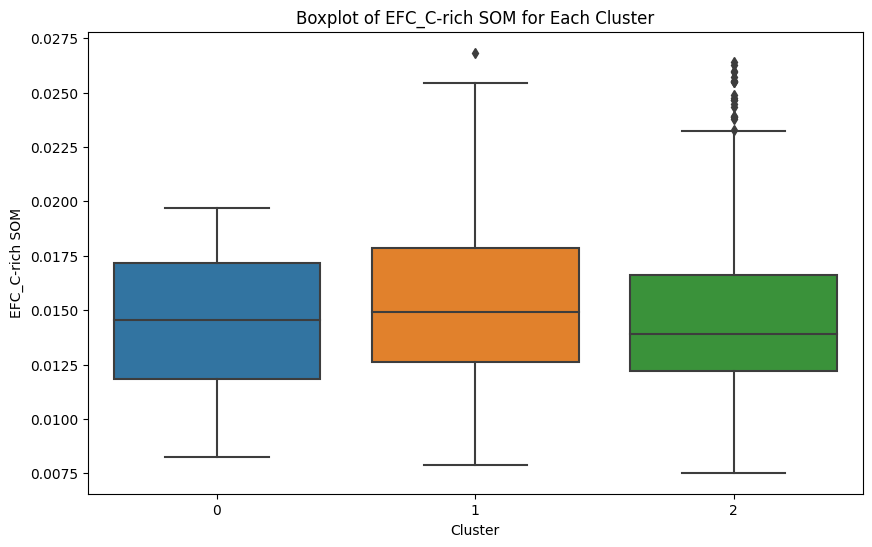

In [24]:
# Creating a boxplot for the distribution of 'EFC_C-rich SOM' within each cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='EFC_C-rich SOM', data=data)
plt.title('Boxplot of EFC_C-rich SOM for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('EFC_C-rich SOM')
plt.show()

In [27]:
# Can I do an ANOVA? 
## result: the p-value for normality is < 0.05, which means that the data don't follow a normal distribution, 
## so I cannot apply an ANOVA.

# Testing for normality and homogeneity of variances
# Normality Test (Shapiro-Wilk test)
normality = stats.shapiro(data['EFC_C-rich SOM'])

# Homogeneity of variances (Levene's test)
homogeneity = stats.levene(data[data['Cluster'] == 0]['EFC_C-rich SOM'],
                           data[data['Cluster'] == 1]['EFC_C-rich SOM'],
                           data[data['Cluster'] == 2]['EFC_C-rich SOM'])

normality, homogeneity

(ShapiroResult(statistic=0.9406741261482239, pvalue=8.577493539930776e-15),
 LeveneResult(statistic=0.4410070348261524, pvalue=0.6435962148529653))

In [28]:
# Let's do a Kruskal-Wallis H-test (which does not assume normality)
## result: p-value > 0.05, which means that the 3 clusters don't have significantly different EFC values.

# Performing Kruskal-Wallis H-test
kruskal_result = stats.kruskal(data[data['Cluster'] == 0]['EFC_C-rich SOM'],
                               data[data['Cluster'] == 1]['EFC_C-rich SOM'],
                               data[data['Cluster'] == 2]['EFC_C-rich SOM'])

kruskal_result

KruskalResult(statistic=4.412481658417846, pvalue=0.11011380807129792)

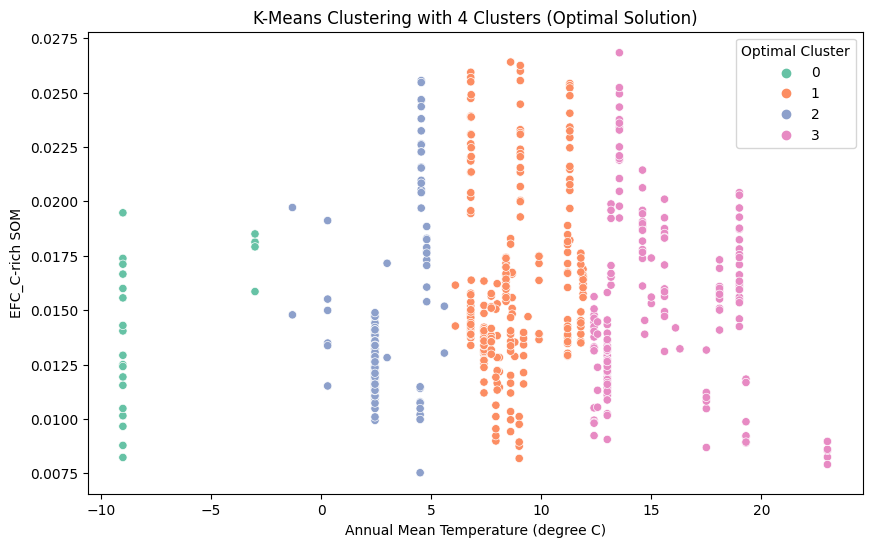

In [3]:
# Find a clustering that does find significant differences, using ML

# Function to find the optimal number of clusters
def find_optimal_k(data, max_clusters):
    for k in range(2, max_clusters + 1):
        # Applying K-means clustering
        kmeans = KMeans(n_clusters=k, random_state=0).fit(data[['Annual Mean Temperature (degree C)', 'EFC_C-rich SOM']])
        data['Cluster'] = kmeans.labels_

        # Preparing data for Kruskal-Wallis H-test
        cluster_groups = [data[data['Cluster'] == cluster]['EFC_C-rich SOM'] for cluster in range(k)]

        # Performing Kruskal-Wallis H-test
        if stats.kruskal(*cluster_groups).pvalue < 0.05:
            return k  # Return the number of clusters if the test is significant
    return None

# Find the optimal number of clusters
optimal_k = find_optimal_k(data, 10)

# Apply K-means clustering with the optimal number of clusters
if optimal_k is not None:
    kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=0).fit(data[['Annual Mean Temperature (degree C)', 'EFC_C-rich SOM']])
    data['Optimal_Cluster'] = kmeans_optimal.labels_

    # Visualizing the optimal clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Annual Mean Temperature (degree C)', y='EFC_C-rich SOM', hue='Optimal_Cluster', palette='Set2', data=data)
    plt.title(f'K-Means Clustering with {optimal_k} Clusters (Optimal Solution)')
    plt.xlabel('Annual Mean Temperature (degree C)')
    plt.ylabel('EFC_C-rich SOM')
    plt.legend(title='Optimal Cluster')
    plt.show()
else:
    print("No optimal number of clusters found.")

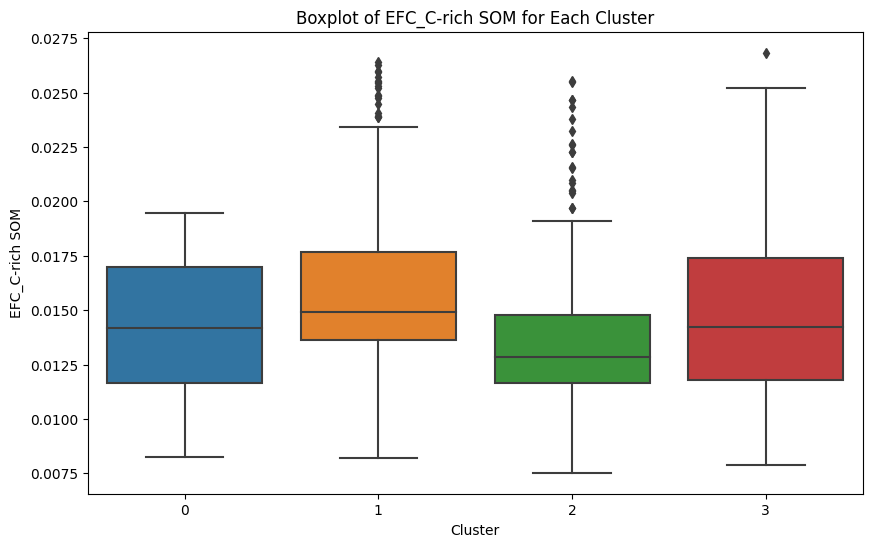

In [4]:
# Creating a boxplot for the distribution of 'EFC_C-rich SOM' within each cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='EFC_C-rich SOM', data=data)
plt.title('Boxplot of EFC_C-rich SOM for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('EFC_C-rich SOM')
plt.show()

In [35]:
# Let's do a Kruskal-Wallis H-test (which does not assume normality)
## result: p-value < 0.05, which means that the 4 clusters have significantly different values.

# Performing Kruskal-Wallis H-test
kruskal_result = stats.kruskal(data[data['Cluster'] == 0]['EFC_C-rich SOM'],
                               data[data['Cluster'] == 1]['EFC_C-rich SOM'],
                               data[data['Cluster'] == 2]['EFC_C-rich SOM'],
                               data[data['Cluster'] == 3]['EFC_C-rich SOM'])

kruskal_result

KruskalResult(statistic=39.10266078875861, pvalue=1.6508860257898604e-08)